# Geodesic Shooting Test in PyTorch
This notebook uses autograd and tensor functionality to implement geodesic shooting on point sets

In [1]:
%matplotlib inline
import gshoot
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.optimize as opt

ImportError: No module named scipy.optimize

In [2]:
# Read some sample data from Matlab
q0_data=torch.Tensor(np.genfromtxt('testdata/test_q.csv', delimiter=','))
p0_data=torch.Tensor(np.genfromtxt('testdata/test_p.csv', delimiter=','))
qT_data=torch.Tensor(np.genfromtxt('testdata/test_trg.csv', delimiter=','))

# Create variables
q0=Variable(q0_data,requires_grad=False)
p0=Variable(p0_data,requires_grad=True)
qT=Variable(qT_data,requires_grad=False)

## Test Forward Flow
Compute the Hamiltonian and first derivs

In [3]:
gs=gshoot.PointSetHamiltonianSystem(q0, 0.08, 100)
H,Hq,Hp=gs.hamiltonian_jet(q0,p0)

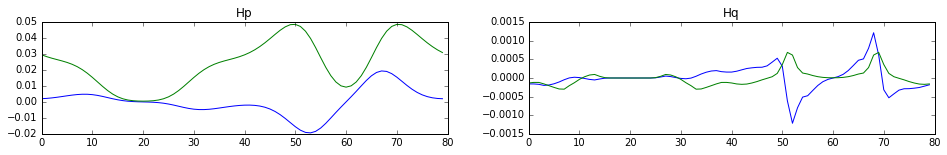

In [4]:
fig,ax = plt.subplots(1,2,figsize=(16,2))
ax[0].set_title("Hp")
ax[0].plot(Hp.data.numpy()[:,0]);
ax[0].plot(Hp.data.numpy()[:,1]);
ax[1].set_title("Hq")
ax[1].plot(Hq.data.numpy()[:,0]);
ax[1].plot(Hq.data.numpy()[:,1]);

Perform actual flow

In [8]:
%%time
(H,q1,p1)=gs.flow(p0)

CPU times: user 263 ms, sys: 9.52 ms, total: 272 ms
Wall time: 270 ms


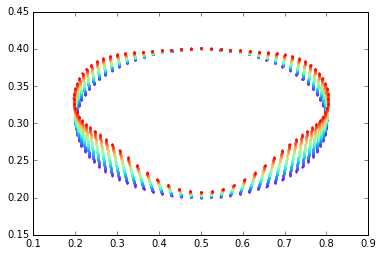

In [9]:
colors = cm.rainbow(np.linspace(0, 1, len(gs.qt)))
for i in range(len(gs.qt)):
    plt.scatter(gs.qt[i].data.numpy()[:,0],gs.qt[i].data.numpy()[:,1],color=colors[i],s=1)
plt.show()

### Test inverse flow

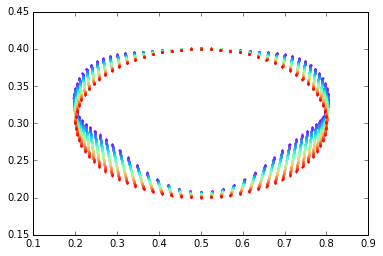

In [10]:
gs_inv=gshoot.PointSetHamiltonianSystem(q1, 0.08, 100)
(H,q2,p2)=gs_inv.flow(-p1)

for i in range(len(gs_inv.qt)):
    plt.scatter(gs_inv.qt[i].data.numpy()[:,0],gs_inv.qt[i].data.numpy()[:,1],color=colors[i],s=1)
plt.show()

### Test on a larger problem - for timing
There must be some overhead due to all the torch stuff - hopefully it becomes negligible as problem increases

In [11]:
# Create the same ellipse problem, but with 400 points
import scipy.interpolate as interp
t80=np.linspace(0,1,80)
t800=np.linspace(0,1,800)
big_q0_data = torch.FloatTensor(
    np.column_stack(
        (interp.interp1d(t80,q0_data.numpy()[:,0])(t800),
         interp.interp1d(t80,q0_data.numpy()[:,1])(t800))))
big_p0_data = torch.FloatTensor(
    np.column_stack(
        (interp.interp1d(t80,p0_data.numpy()[:,0])(t800),
         interp.interp1d(t80,p0_data.numpy()[:,1])(t800))))
big_q0=Variable(big_q0_data,requires_grad=False)
big_p0=Variable(big_p0_data,requires_grad=True)

big_gs=gshoot.PointSetHamiltonianSystem(big_q0, 0.08, 100)
big_gs_t=gshoot.PointSetHamiltonianSystem(big_q0_data, 0.08, 100)

Time on Variable objects

In [12]:
%%time
(H,big_q1,big_p1)=big_gs.flow(big_p0)

CPU times: user 3.3 s, sys: 317 ms, total: 3.62 s
Wall time: 3.36 s


Time on tensors (no graphs computed)

In [14]:
%%time
(H,big_q1_data,big_p1_data)=big_gs_t.flow(big_p0_data)

CPU times: user 1.44 s, sys: 44.2 ms, total: 1.49 s
Wall time: 1.32 s


## Test autograd and fitting to target data
Our goal is to expand the ellipse to a larger circle

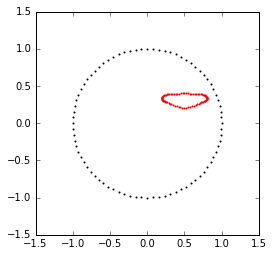

In [15]:
plt.figure(figsize=plt.figaspect(1.0))
plt.scatter(qT.data.numpy()[:,0],qT.data.numpy()[:,1],s=1);
plt.scatter(q1.data.numpy()[:,0],q1.data.numpy()[:,1],color='red',s=1);

Compute the objective and backprop

In [16]:
%%time
obj=torch.dist(q1,qT)
obj.backward()

CPU times: user 413 ms, sys: 1.79 ms, total: 415 ms
Wall time: 414 ms


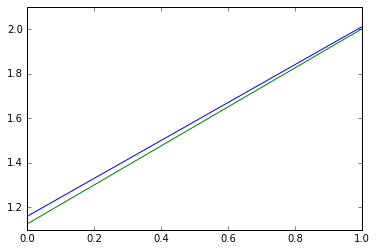

In [17]:
plt.plot(p0.grad.data.numpy()[0]);
plt.plot(p0.grad.data.numpy()[1]);

In [27]:
def objfun(x,*args):
    my_p0 = Variable(torch.FloatTensor(x.reshape(gs.q0.size())), requires_grad=False)
    (H,q1,p1) = gs.flow(my_p0)
    my_res = 1 * H + torch.dist(q1,qT)
    return my_res.data.numpy()[0]
    
def objgrad(x,*args):
    my_p0 = Variable(torch.FloatTensor(x.reshape(gs.q0.size())), requires_grad=True)
    (H,q1,p1) = gs.flow(my_p0)
    obj = 1 * H + torch.dist(q1,qT)
    print(H.data.numpy()[0], torch.dist(q1,qT).data.numpy()[0],obj.data.numpy()[0])
    obj.backward()
    grad_obj = my_p0.grad.data
    return grad_obj.view(-1).numpy()

In [28]:
objfun(p0.data.numpy().reshape(-1))

10.617319

In [29]:
%%time
x=p0.data.numpy().reshape(-1);
opt_options={'maxiter':20,'disp':True}
res=opt.minimize(objfun,x,method='CG',jac=objgrad,options=opt_options)

(0.0029951683, 10.614324, 10.617319)
(8.2766361, 7.4160557, 15.692692)
(0.76613206, 8.0746384, 8.8407707)
(3.4878325, 7.0765409, 10.564373)
(1.1840923, 7.1482506, 8.3323431)
(1.52013, 6.6274714, 8.1476011)
(1.3105581, 6.6817369, 7.9922953)
(1.3379382, 6.4935803, 7.8315187)
(1.4161273, 6.5111532, 7.9272804)
(1.35734, 6.3559804, 7.7133203)
(1.3391007, 6.1764488, 7.5155497)
(1.3227007, 6.0953526, 7.4180536)
(1.3625367, 6.4241977, 7.7867346)
(1.3205488, 5.9953928, 7.3159418)
(1.3188471, 5.9126449, 7.231492)
(1.3162404, 5.8802261, 7.1964664)
(1.3151846, 5.8594351, 7.1746197)
(1.3328077, 5.7762537, 7.1090612)
(1.3767735, 5.7246103, 7.1013837)
(1.3519551, 5.7180653, 7.0700202)
(1.381574, 5.6417804, 7.0233545)
(1.4288585, 5.5132504, 6.9421091)
(1.5319524, 5.4987769, 7.0307293)
(1.4559405, 5.4674797, 6.92342)
(1.5807401, 5.7933393, 7.3740792)
(1.4712058, 5.429481, 6.9006867)
(1.4808105, 5.4159799, 6.8967905)
(1.5206648, 5.3438311, 6.8644958)
(1.5399872, 5.3057384, 6.8457255)
(1.5341704, 5.30777

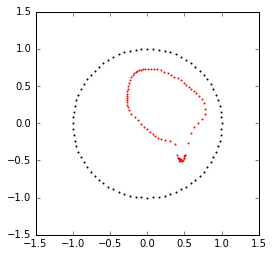

In [30]:
(H,q1,p1) = gs.flow(Variable(torch.FloatTensor(res.x.reshape(gs.q0.size())), requires_grad=True))
plt.figure(figsize=plt.figaspect(1.0))
plt.scatter(qT.data.numpy()[:,0],qT.data.numpy()[:,1],s=1);
plt.scatter(q1.data.numpy()[:,0],q1.data.numpy()[:,1],color='red',s=1);